In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import py0
import maxent
import tqdm
import seaborn as sns
import tensorflow as tf
import geoplot.crs as gcrs
import os
import sys

Obtaining data from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
https://github.com/CSSEGISandData/COVID-19

In [2]:
# Loading real confirmed covid data from :
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
data_confirmed=pd.read_csv('time_series_covid19_confirmed_US.txt', sep=',', low_memory=False)
data_confirmed =data_confirmed.loc[data_confirmed['Province_State']=='New York']
# data = data.loc[:, ~data.columns.isin(['Out of NY'])]
mask = data_confirmed['Admin2'].isin(['Out of NY', 'Unassigned'])
data_confirmed = data_confirmed[~mask]

# Loading real deaths covid data
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
data_deaths=pd.read_csv('time_series_covid19_deaths_US.txt',sep=',', low_memory=False)
data_deaths = data_deaths.loc[data_deaths['Province_State']=='New York']
mask = data_deaths['Admin2'].isin(['Out of NY', 'Unassigned'])
data_deaths = data_deaths[~mask]
population = data_deaths[data_deaths.columns[11]].to_list()

A_deaths = data_deaths[data_deaths.columns[12:73]].transpose()
B_deaths = data_deaths[data_deaths.columns[12:73]].transpose().shift(1)
real_deaths = np.array((A_deaths-B_deaths).fillna(0))

A_confirmed = data_confirmed[data_confirmed.columns[11:74]].transpose()
B_confirmed = data_confirmed[data_confirmed.columns[11:74]].transpose().shift(1)
real_infected = np.array((A_confirmed-B_confirmed).fillna(0))
real_infected_fr = real_infected/population

In [6]:
# Loading County names
results=pd.read_csv('data/Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('data/countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population_fraction = population/np.sum(population)
area =pd.read_csv('data/areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

# load mobility matrix
networkCounty=pd.read_csv('data/networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']

# defining mobility matrix
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)

# Getting observations

Obtaining two weekly-averaged data points from the number of confirmed disease cases from 20 random counties

In [5]:
compartments = ['I']
infections_compartments = [0]
full_compartments = ['S'] + compartments
npoints = 2
prior = maxent.Laplace(1)

number_of_restrained_patches = 20 
restrained_compartments = [3] #(infected patch)

number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
dummy_ref_traj = np.repeat(real_infected_fr[np.newaxis, ..., np.newaxis], 4, axis=-1)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches,
                                                    restrained_compartments, dummy_ref_traj, prior, npoints=npoints,
                                                    noise=0.1, start_time=50, end_time=63)

Restraints are set in this time range: [50, 63]
52 0.0 1.0000000000000013e-15
59 7.002343450941583e-06 6.320323714994594e-06
52 1.7749536293364336e-06 1.7700786773628982e-06
59 8.874768146682167e-06 8.621802905697778e-06
59 5.804723303351938e-06 6.433342930995003e-06
52 2.902361651675969e-06 2.9163011302229365e-06
52 9.287739690197768e-06 9.441328462287378e-06
59 0.0001725004152877356 0.00016758929567691375
52 2.963656678155776e-06 3.1359921787961266e-06
59 0.0 1.0000000000000013e-15
59 0.0 1.0000000000000013e-15
52 0.0 1.0000000000000013e-15
59 0.0 1.0000000000000013e-15
52 0.0 1.0000000000000013e-15
52 0.0 1.0000000000000013e-15
59 6.812020036421601e-06 7.109872093596603e-06
52 0.0 1.0000000000000013e-15
59 2.4012428833164047e-06 2.0657753220747547e-06
59 6.469979296066253e-05 5.6347320459635297e-05
52 0.0 1.0000000000000013e-15
59 0.0 1.0000000000000013e-15
52 0.0 1.0000000000000013e-15
59 0.00028458384326753114 0.00025381286076026874
52 7.89292631558638e-06 7.342754623179282e-06
52

# Generating samples

We assume a single individual exposed to the disease at time zero in a single random county.

In [8]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
eta = 1/3
# alpha = 1/4
mu = 1/14
# epsilon = 0.6
tmat.add_transition('E', 'A', 3, 4) # call this alpha
tmat.add_transition('E', 'I', 3, 4) # call this gamma
tmat.add_transition('A', 'R',14, 6) # mu
tmat.add_transition('I', 'R', 14, 6) # mu


print(tmat.value)
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.001]*2
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = [0.025]*2
hyper_pram.beta_var = [0.5]*2
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 2e-4
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.01
hyper_pram.start_mean = 5e-5
hyper_pram.start_scale = 1e-7

start_logits = np.zeros((M))
param_model = py0.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram, n_infectious_compartments=2)

[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.92857143 0.         0.07142857]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [10]:
import tqdm
# N = 16384
Time = 63
N = 2048
batches = 16
total_batches= N*batches
outs = []
infect = py0.contact_infection_func(infections_compartments, area = area)
# model = py0.MetaModel(infect, Time,populations = np.round(population))
model = py0.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]

prior_exposed_patch = py0.exposed_finder(trajs)

100%|██████████| 16/16 [01:47<00:00,  6.69s/it]


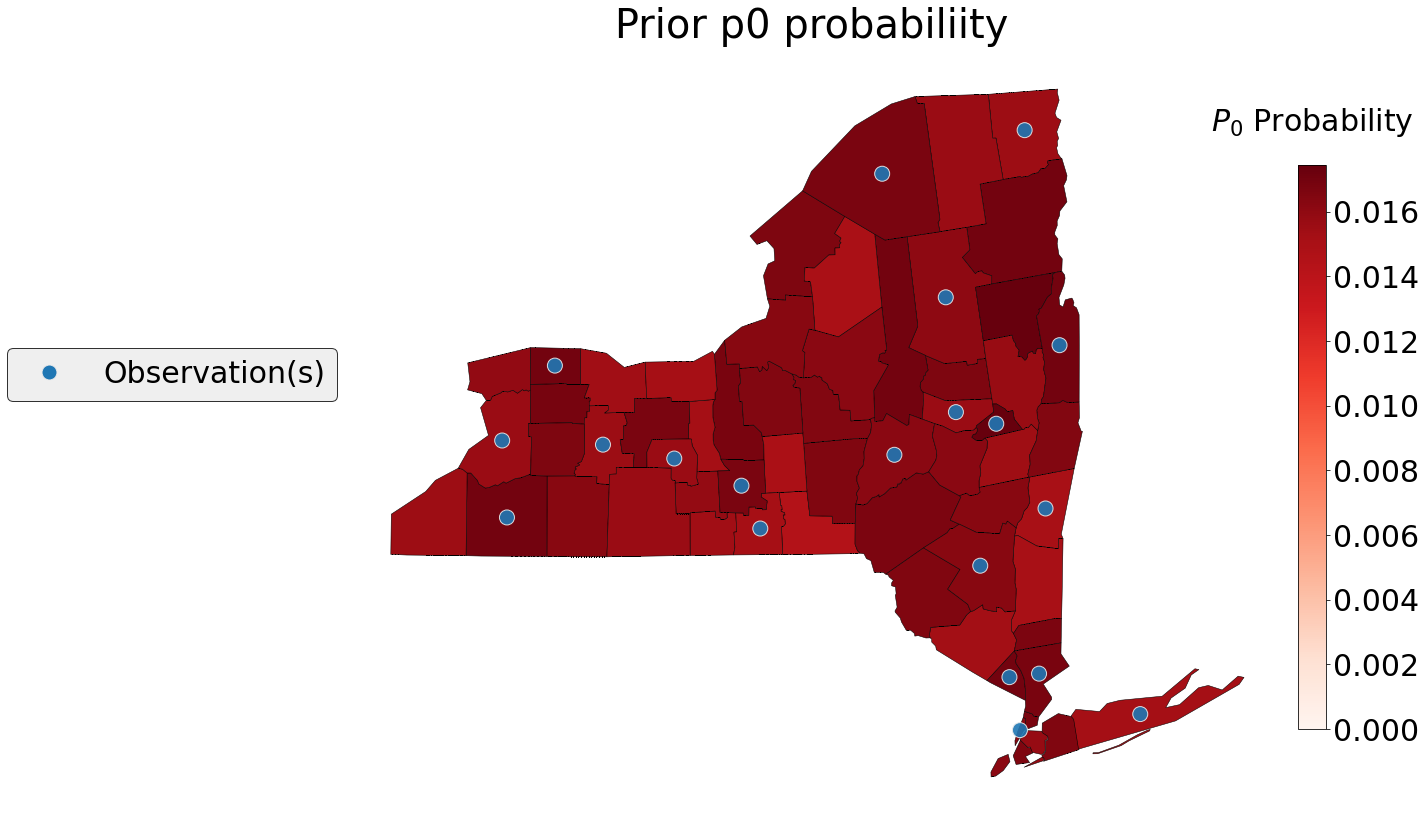

In [21]:
geojson_NY = 'data/counties_ny.geojson'
font_size = 30
title = 'Prior p0 probabiliity '
py0.p0_map(prior_exposed_patch, M, weights=None, patch_names=patches, fontsize=font_size,
           choropleth=True, geojson=geojson_NY,
           true_origin=None, restrained_patches=restrained_patches,
           obs_size=15, vmin=0, vmax=None, figsize=(20, 20),
           show_cbar=True, show_legend=True, ax=None, 
           projection= gcrs.AlbersEqualArea(
                central_longitude=-78, central_latitude=39.5), title=title)

# MaxEnt Fit

In [23]:
import tensorflow as tf
me_model = maxent.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=5, min_lr=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0)

me_history = me_model.fit(trajs, batch_size=N, epochs=1000, callbacks=[reduce_lr], verbose=0)#, callbacks=[CustomCallback()])

me_w = me_model.traj_weights

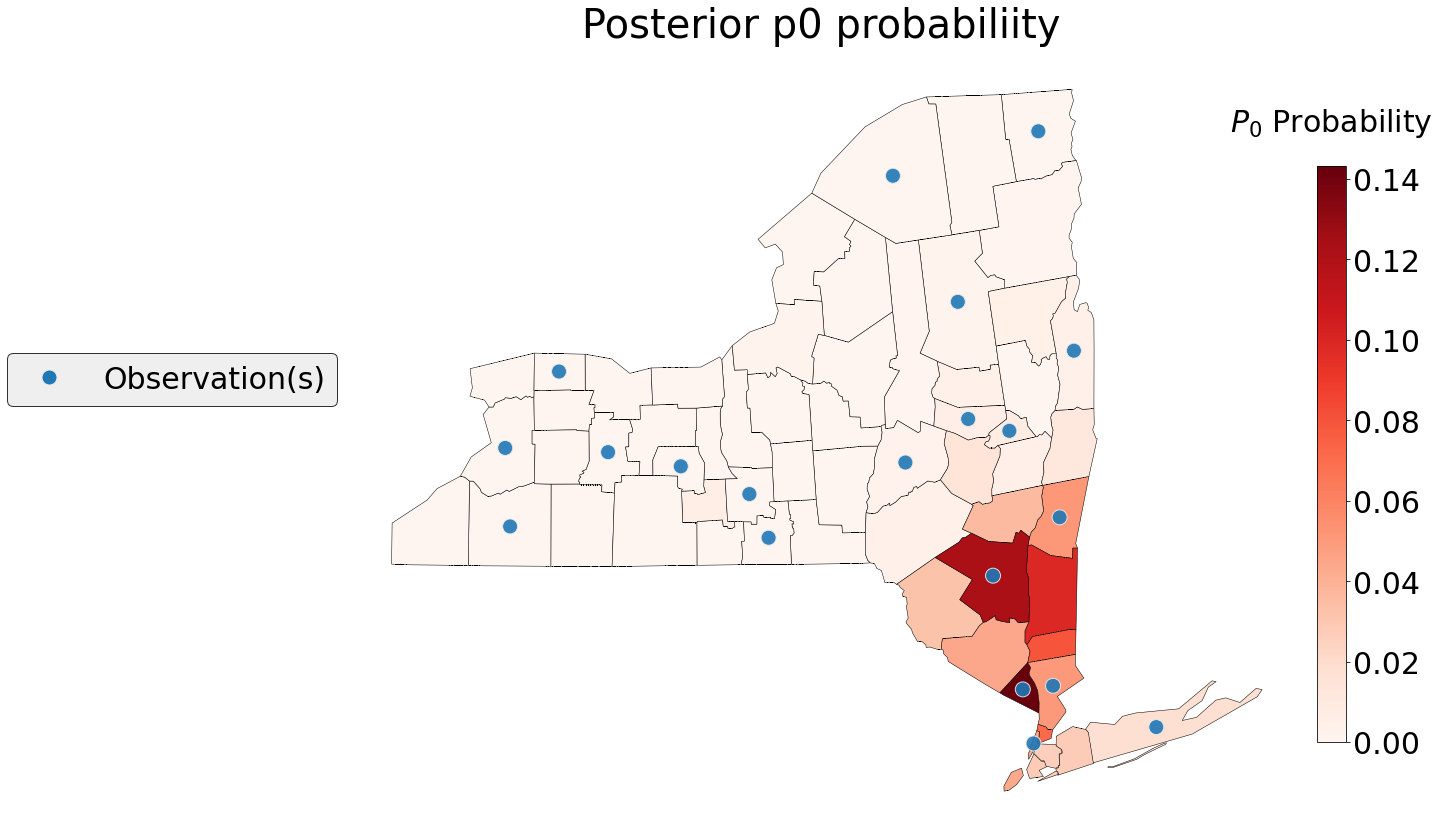

In [24]:
title = 'Posterior p0 probabiliity '
py0.p0_map(prior_exposed_patch, M, weights=me_w, patch_names=patches, fontsize=font_size,
           choropleth=True, geojson=geojson_NY,
           true_origin=None, restrained_patches=restrained_patches,
           obs_size=15, vmin=0, vmax=None, figsize=(20, 20),
           show_cbar=True, show_legend=True, ax=None, 
           projection= gcrs.AlbersEqualArea(
                central_longitude=-78, central_latitude=39.5), title=title)

In [25]:
posterior_exposed_prob = py0.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
posterior_P0 = dict(zip(patches,posterior_exposed_prob))
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:10]

[(0.14313938354131606, 'Rockland County'),
 (0.12265641782538081, 'Ulster County'),
 (0.09919433732654266, 'Dutchess County'),
 (0.0795239692192039, 'Putnam County'),
 (0.0710622103521064, 'Bronx County'),
 (0.05172953609990754, 'Columbia County'),
 (0.050390152617582486, 'Westchester County'),
 (0.04506398190868647, 'New York County'),
 (0.0442874637382198, 'Orange County'),
 (0.04379825114409653, 'Richmond County')]